# Experimentation 

This notebook is simply me testing and seeing the results, I'll try to replicate the results in the paper and build from there, then when i have a better grasp ill start writing a proper problem and solver classes. 



In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Units 
# Q in Å^{-1}
# thickness d 
# roughness sigma in Å
# SLDs rho in Å^{-2}



def kz(Q, rho):
    """
    z-wavevector in a layer for given SLD rho
    """
    return np.sqrt((Q**2)/4.0 - 4.0*np.pi*rho + 0j)  # 0j to allow complex

# an atempt of parratt recursive method for reflecteivity
# http://phys.iit.edu/~segre/phys570/10F/lecture_13.pdf 
def reflectivity(Q, layers, roughness, spin='up', F=None, bkg=0.0):
    sgn = +1 if spin == 'up' else -1 #regular sgn func with spin 
    N = len(layers) - 1  # last is substrate

    rho_s = [L['rho_n'] + sgn * L.get('rho_m', 0.0) for L in layers]
    k = [kz(Q, r) for r in rho_s]

    Gamma = np.zeros_like(Q, dtype=np.complex128)

    for j in range(N-1, -1, -1):
        rj = (k[j] - k[j+1]) / (k[j] + k[j+1])
        sigma = roughness[j] if j < len(roughness) else 0.0
        rj *= np.exp(-2.0 * k[j] * k[j+1] * (sigma**2))

        dj1 = layers[j+1].get('d', 0.0)
        phase = np.exp(2j * k[j+1] * dj1)

        Gamma = (rj + Gamma * phase) / (1.0 + rj * Gamma * phase)

    R = np.abs(Gamma)**2
    if F is not None:
        R = F(Q) * R
    return R + bkg

## Dependencies

In [12]:
import os 
import sys
sys.path.append(os.path.abspath(".."))

In [13]:
import numpy as np 
import matplotlib.pyplot
from src.physics.fom import sensitivity, sfm, mcf, tsf 
from src.physics.reflectometry import reflectivity, spin_sld

## Constants 

The constants used in the paper 

In [14]:
RHO_AIR = 0.0
RHO_SI  = 2.07e-6
RHO_N_Co =  2.26e-6
RHO_N_Ti = -1.95e-6
RHO_M_Co_SAT = 2.7e-6


B_T = 0.020   
B_SAT = 0.010 

MRL_LIBRARY = {
    "None":  {"rho_n": 0.0,   "rho_m": 0.0,  "d": 0.0, "sigma": 0.0}, 
    "Fe": {"rho_n": 8.0e-6, "rho_m": 5.0e-6, "d": 100.0, "sigma": 5.0},
    "Ni": {"rho_n": 9.4e-6, "rho_m": 1.0e-6, "d": 100.0, "sigma": 5.0},
    "CoTi": {"rho_n": 1.0e-6, "rho_m": 2.0e-6, "d": 100.0, "sigma": 5.0},
}

RHO_CAP = 3.45e-6
D_CAP   = 16.0
SIG_CAP_SOI = 8.6

SOI_SLDs = [1.0e-6, 2.0e-6, 3.0e-6]
SOI_TYPES = {
    "normal": {"d": 500.0, "sigma_SOI_sub": 3.0,  "sigma_SOI": 15.0},
    "rough":{"d": 500.0, "sigma_SOI_sub": 3.0,"sigma_SOI": 50.0},
    "thin": {"d":  50.0, "sigma_SOI_sub": 3.0, "sigma_SOI": 15.0},}


Q = np.linspace(0.005, 0.25, 2000)   # Å^-1
BKG = 1e-3

# Build stack 

In [15]:
def build_layers_for_spin(mrl_name, soi_rho_n=None, soi_d=0.0, spin="up"):
    """Return (layers, sigmas) for reflectivity(). If soi_rho_n is None -> no SOI (R_sub)."""
    m = MRL_LIBRARY[mrl_name]
    rho_mrl = spin_sld(m["rho_n"], m["rho_m"], spin)
    layers = [
        {"rho": RHO_AIR, "d": 0.0},               # ambient
        {"rho": rho_mrl, "d": m["d"]},            # MRL
        {"rho": RHO_CAP, "d": D_CAP},             # cap
    ]
    sigmas = [
        m["sigma"],   # Air|MRL
        m["sigma"],   # MRL|Cap
    ]
    if soi_rho_n is not None and soi_d > 0:
        layers.append({"rho": soi_rho_n, "d": soi_d})   # SOI
        sigmas.append(SIG_CAP_SOI)                      # Cap|SOI
    # substrate (semi-infinite)
    layers.append({"rho": RHO_SI, "d": 0.0})
    # SOI|Substrate roughness depends on SOI type; we add it later where we know the type
    return layers, sigmas

def reflect_pair(Q, mrl_name, soi, spin):
    """Compute R_sub and R_full for a given spin channel and SOI spec."""
    # With SOI (full)
    layers_f, sigmas_f = build_layers_for_spin(
        mrl_name, soi_rho_n=soi["rho_n"], soi_d=soi["d"], spin=spin
    )
    sigmas_f = sigmas_f + [soi["sigma_SOI_sub"]]  # add SOI|Sub roughness
    R_full = reflectivity(Q, layers_f, sigmas_f, bkg=BKG)

    # Without SOI (substrate reference)
    layers_s, sigmas_s = build_layers_for_spin(mrl_name, soi_rho_n=None, soi_d=0.0, spin=spin)
    sigmas_s = sigmas_s + [soi["sigma_SOI_sub"]]  # Cap|Sub interface roughness for reference stack
    R_sub = reflectivity(Q, layers_s, sigmas_s, bkg=BKG)
    return R_sub, R_full

# Reproducing paper results

In [16]:
def compute_foms_for_case(mrl_name, soi_type, soi_rho_n):
    spec = {
        "rho_n": soi_rho_n,
        "d": SOI_TYPES[soi_type]["d"],
        "sigma_SOI": SOI_TYPES[soi_type]["sigma_SOI"],           # (not used directly here)
        "sigma_SOI_sub": SOI_TYPES[soi_type]["sigma_SOI_sub"],   # used at SOI|Sub interface
    }
    # spin-up
    Rsub_u, Rfull_u = reflect_pair(Q, mrl_name, spec, "up")
    S_up = sensitivity(Q, Rsub_u, Rfull_u)
    SFM_up = sfm(Q, S_up)

    # spin-down
    Rsub_d, Rfull_d = reflect_pair(Q, mrl_name, spec, "down")
    S_dn = sensitivity(Q, Rsub_d, Rfull_d)
    SFM_down = sfm(Q, S_dn)

    # magnetic contrast figure
    MCF = mcf(Q, S_up, S_dn)
    return SFM_up, SFM_down, MCF

def compute_tsf(mrl_name):
    triplets = []
    for t in ["normal", "rough", "thin"]:
        for rho in SOI_SLDs:
            triplets.append(compute_foms_for_case(mrl_name, t, rho))
    return tsf(triplets), triplets

def plot_tsf_bars():
    mrls = ["None", "Fe", "Ni", "CoTi"]
    tsfs = [compute_tsf(name)[0] for name in mrls]
    plt.figure()
    plt.bar(mrls, tsfs)
    plt.title("TSF by Magnetic Reference Layer")
    plt.xlabel("MRL"); plt.ylabel("TSF (arb. units)")
    plt.tight_layout()
    plt.show()

def plot_reflectivity_examples():
    rep_mrl = "CoTi"
    rep_soi = {"rho_n": 2.0e-6, "d": 500.0, "sigma_SOI_sub": 3.0}

    # spin up
    Rsub_u, Rfull_u = reflect_pair(Q, rep_mrl, rep_soi, "up")
    plt.figure()
    plt.semilogy(Q, Rfull_u, label="R_up (with SOI)")
    plt.semilogy(Q, Rsub_u, label="R_up (reference)")
    plt.title(f"Reflectivity (spin up) — {rep_mrl}, SOI d=500Å, ρ=2e-6")
    plt.xlabel("Q (Å$^{-1}$)"); plt.ylabel("R")
    plt.legend(); plt.tight_layout(); plt.show()

    # spin down
    Rsub_d, Rfull_d = reflect_pair(Q, rep_mrl, rep_soi, "down")
    plt.figure()
    plt.semilogy(Q, Rfull_d, label="R_down (with SOI)")
    plt.semilogy(Q, Rsub_d, label="R_down (reference)")
    plt.title(f"Reflectivity (spin down) — {rep_mrl}, SOI d=500Å, ρ=2e-6")
    plt.xlabel("Q (Å$^{-1}$)"); plt.ylabel("R")
    plt.legend(); plt.tight_layout(); plt.show()

    return (Rsub_u, Rfull_u, Rsub_d, Rfull_d)

def plot_sensitivity_from_reflectivity(Rsub_u, Rfull_u, Rsub_d, Rfull_d):
    S_up = sensitivity(Q, Rsub_u, Rfull_u)
    S_dn = sensitivity(Q, Rsub_d, Rfull_d)
    plt.figure()
    plt.plot(Q, S_up, label="S_up")
    plt.plot(Q, S_dn, label="S_down")
    plt.title("Sensitivity S(Q) — CoTi, SOI d=500Å, ρ=2e-6")
    plt.xlabel("Q (Å$^{-1}$)"); plt.ylabel("S(Q)")
    plt.legend(); plt.tight_layout(); plt.show()

def rho_n_mrl(xCo):  # linear mix
    return RHO_N_Co*xCo + RHO_N_Ti*(1.0 - xCo)

def rho_m_mrl(xCo, B=B_T):
    sat = np.tanh(B / B_SAT) if B_SAT > 0 else 1.0
    return xCo * RHO_M_Co_SAT * sat

def tsf_for_comp(xCo):
    # temporarily inject a composition dependent MRL
    MRL_LIBRARY["_tmp"] = {"rho_n": rho_n_mrl(xCo), "rho_m": rho_m_mrl(xCo), "d": 100.0, "sigma": 5.0}
    val, _ = compute_tsf("_tmp")
    return val

def plot_tsf_vs_composition():
    xgrid = np.linspace(0.0, 1.0, 51)
    tsf_grid = np.array([tsf_for_comp(x) for x in xgrid])
    plt.figure()
    plt.plot(xgrid, tsf_grid)
    plt.title("TSF vs Co fraction in Co–Ti MRL")
    plt.xlabel("x(Co) in Co$_x$Ti$_{1-x}$"); plt.ylabel("TSF (arb. units)")
    plt.tight_layout(); plt.show()



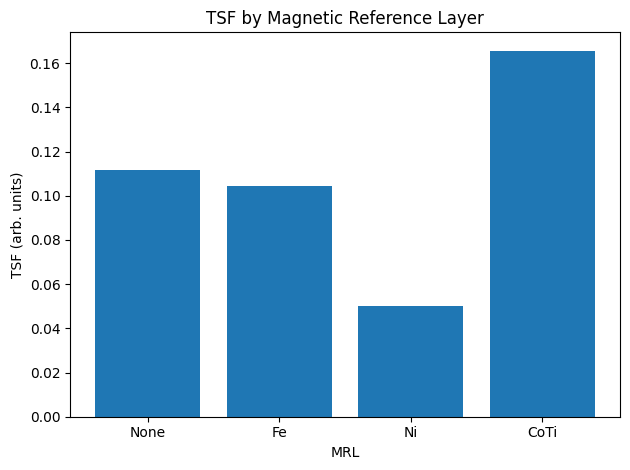

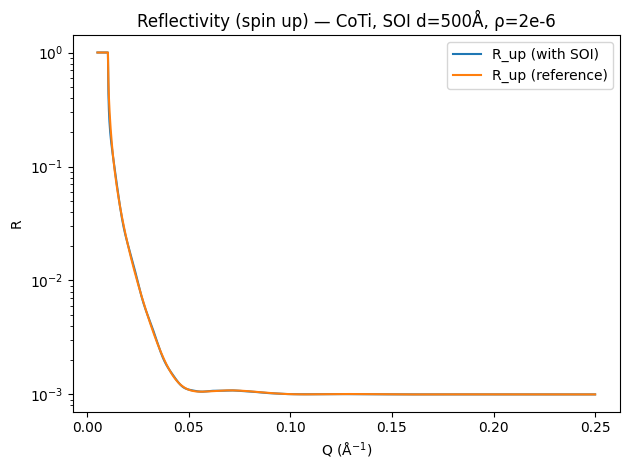

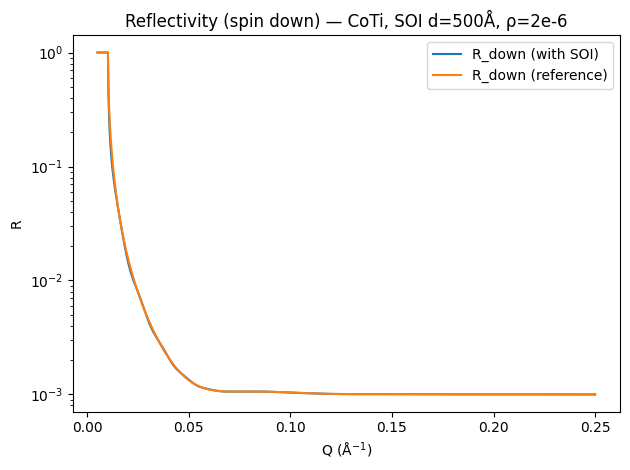

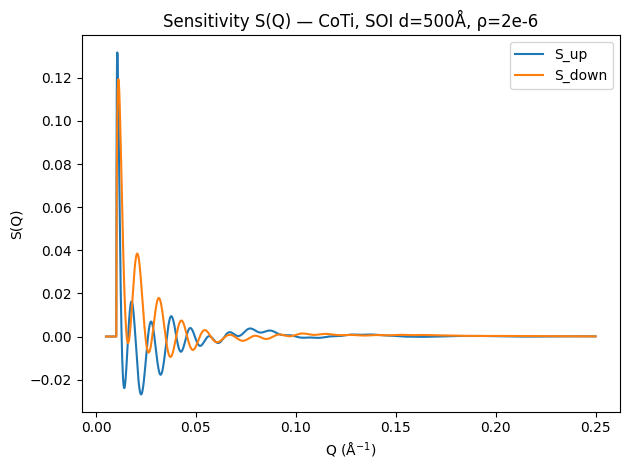

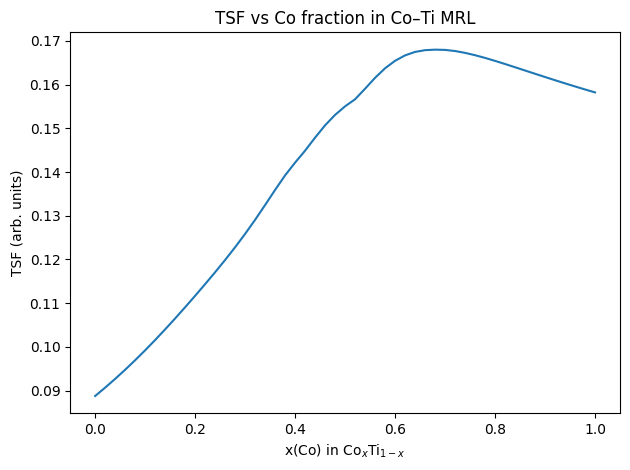

In [18]:
plot_tsf_bars()
Rsub_u, Rfull_u, Rsub_d, Rfull_d = plot_reflectivity_examples()
plot_sensitivity_from_reflectivity(Rsub_u, Rfull_u, Rsub_d, Rfull_d)
plot_tsf_vs_composition()


In [ ]:
mrls = ["None", "Fe", "Ni", "CoTi"]
print("Q-range:", Q[0], "->", Q[-1], "Å^-1,   background =", BKG)
print("\nTSF by MRL:\n")
for name in mrls:
    TSF, _ = compute_tsf(name)
    print(f"{name:>4s} : TSF = {TSF:.6g}")

print("\nDetail for 'normal' SOI (d=500 Å, sigma=15 Å) across SLDs 1/2/3e-6:")
for name in mrls:
    row = []
    for rho in SOI_SLDs:
        Su, Sd, Mcf = compute_foms_for_case(name, "normal", rho)
        row.append(f"{Su+Sd+Mcf:.4f}")
    print(f"{name:>4s} :", "  ".join(row))

Q-range: 0.005 → 0.25 Å^-1,   background = 0.001

TSF by MRL (higher is better):

None : TSF = 0.111583
  Fe : TSF = 0.104628
  Ni : TSF = 0.0498887
CoTi : TSF = 0.165665

Detail for 'normal' SOI (d=500 Å, σ=15 Å) across SLDs 1/2/3e-6:
None : 0.0143  0.0019  0.0213
  Fe : 0.0153  0.0018  0.0188
  Ni : 0.0071  0.0009  0.0084
CoTi : 0.0273  0.0024  0.0282
